In [54]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test_labels.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train-processed-seqlen128.csv


In [154]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [55]:
import matplotlib as plt
import seaborn as sns

In [56]:
df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")


In [57]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [58]:
# Check for missing data
missing_data = df.isnull().sum()
print("Missing Data:\n", missing_data)

if missing_data.sum() == 0:
    print("No missing data in the dataset.")
else:
    print("There is missing data in the dataset.")

Missing Data:
 id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
No missing data in the dataset.


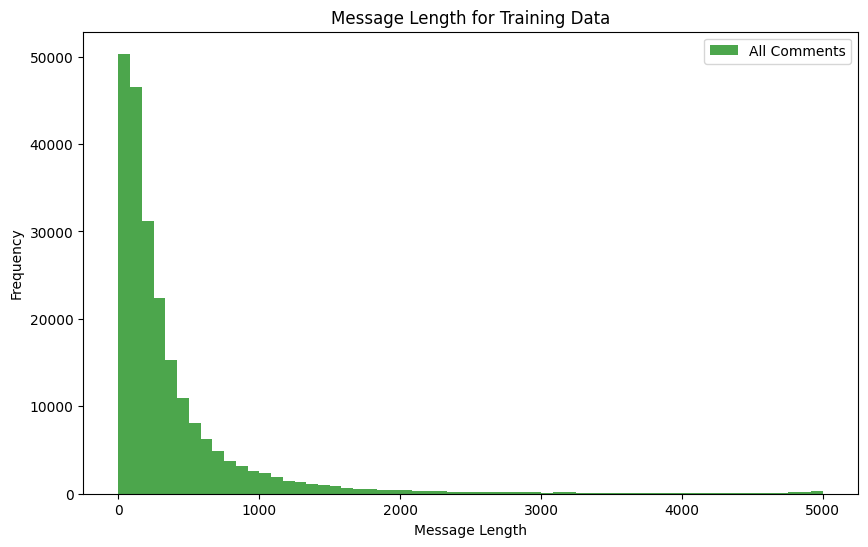

In [59]:
# Calculate message lengths based on the comment_text column
df['message_length'] = df['comment_text'].str.len()

# Plot message length vs. frequency
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['message_length'], bins=60, color='green', alpha=0.7, label='All Comments')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.title('Message Length for Training Data')
plt.legend()
plt.show()


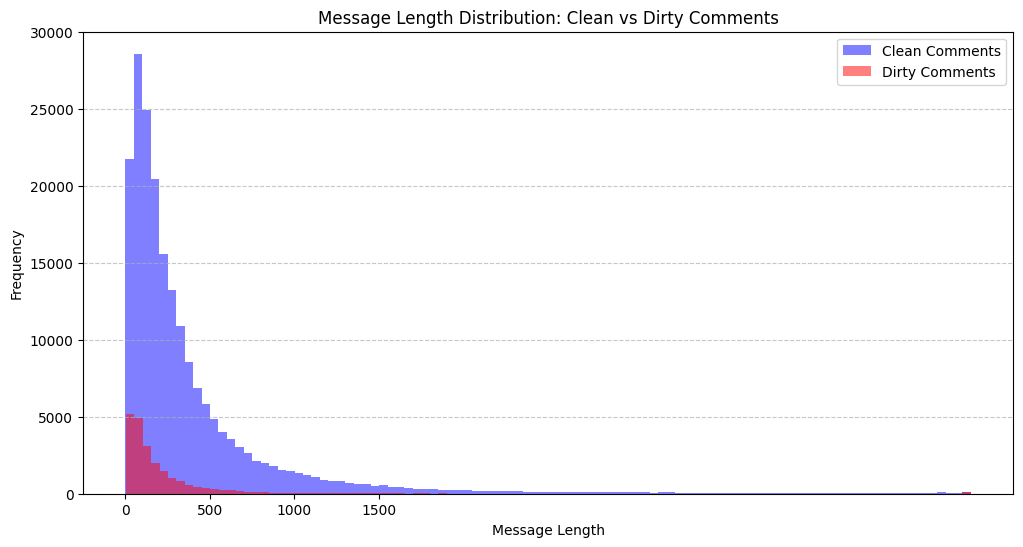

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate message lengths
df['message_length'] = df['comment_text'].str.len()

# Determine if a comment is dirty or clean
df['is_dirty'] = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0

# Separate clean and dirty comments
clean_comments = df[df['is_dirty'] == False]['message_length']
dirty_comments = df[df['is_dirty'] == True]['message_length']

# Plot message length vs. frequency for clean and dirty comments
plt.figure(figsize=(12, 6))
plt.hist(clean_comments, bins=100, color='blue', alpha=0.5, label='Clean Comments')
plt.hist(dirty_comments, bins=100, color='red', alpha=0.5, label='Dirty Comments')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.title('Message Length Distribution: Clean vs Dirty Comments')
plt.legend()
plt.xticks(ticks=range(0, 2000, 500))  # Adjusting x-axis ticks for better scaling
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


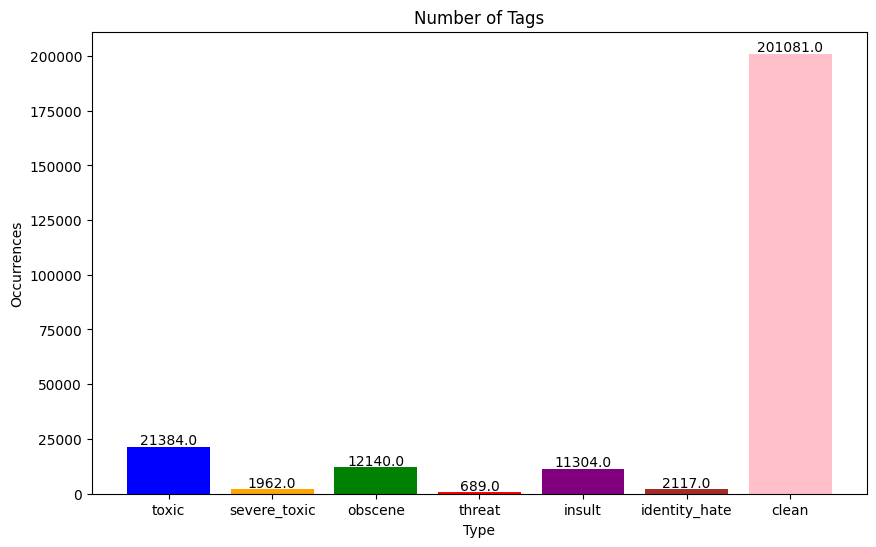

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the number of occurrences for each tag
tag_counts = {
    'toxic': df['toxic'].sum(),
    'severe_toxic': df['severe_toxic'].sum(),
    'obscene': df['obscene'].sum(),
    'threat': df['threat'].sum(),
    'insult': df['insult'].sum(),
    'identity_hate': df['identity_hate'].sum(),
    'clean': (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) == 0).sum()
}

# Convert the dictionary into a DataFrame for easy plotting
tag_counts_df = pd.DataFrame(list(tag_counts.items()), columns=['Type', 'Occurrences'])

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(tag_counts_df['Type'], tag_counts_df['Occurrences'], color=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink'])
plt.xlabel('Type')
plt.ylabel('Occurrences')
plt.title('Number of Tags')
# Annotating the bar values
for i, val in enumerate(tag_counts_df['Occurrences']):
    plt.text(i, val + 1000, f'{val:.1f}', ha='center', fontsize=10)
plt.show()


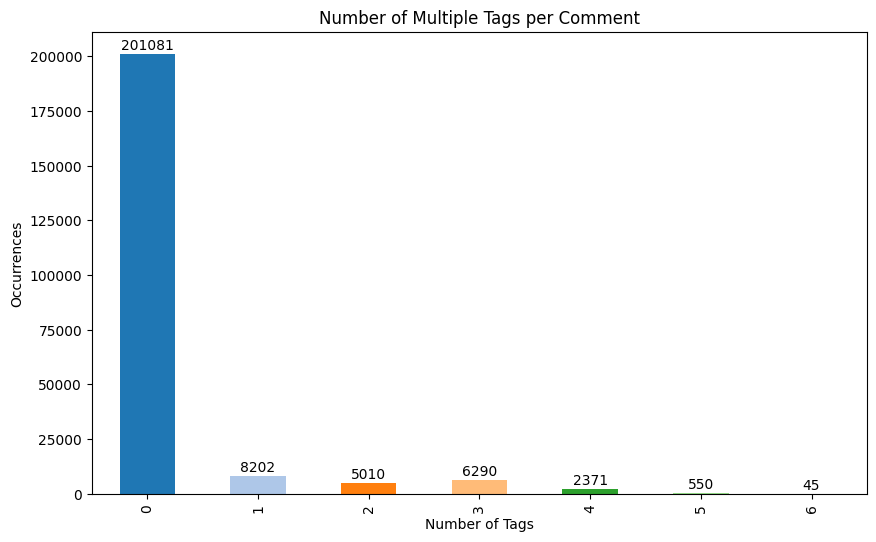

In [62]:
tag_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df['num_tags'] = df[tag_columns].sum(axis=1)

# Count occurrences of each number of tags
tag_counts = df['num_tags'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
bar_colors = plt.cm.tab20(range(len(tag_counts)))  # Optional: Colorful bars
tag_counts.plot(kind='bar', color=bar_colors)
plt.title('Number of Multiple Tags per Comment')
plt.xlabel('Number of Tags')
plt.ylabel('Occurrences')

# Annotate bar plot with numbers
for index, value in enumerate(tag_counts):
    plt.text(index, value + 500, str(value), ha='center', va='bottom', fontsize=10)

plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


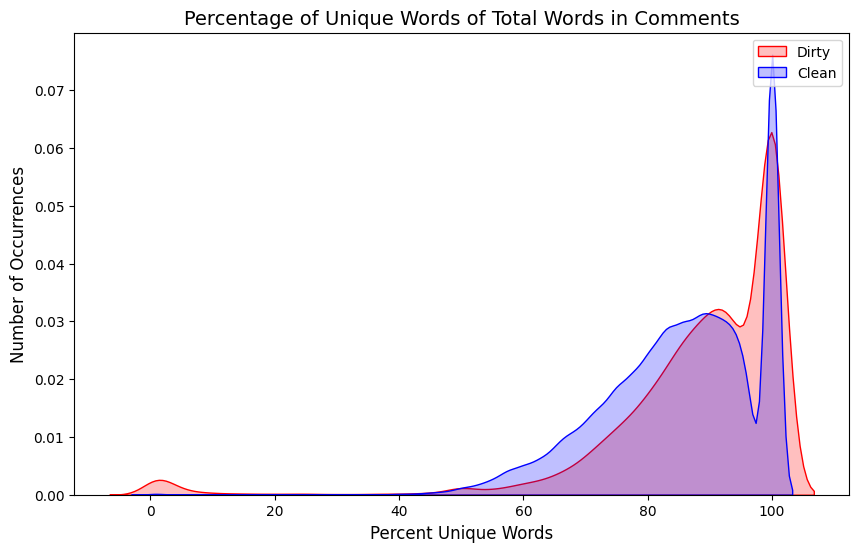

In [63]:
# Function to calculate the percentage of unique words in a comment
def percent_unique_words(text):
    words = text.split()  # Split comment into words
    if len(words) == 0:
        return 0
    unique_words = set(words)
    return len(unique_words) / len(words) * 100

# Add a new column for the percentage of unique words
df["percent_unique_words"] = df["comment_text"].apply(percent_unique_words)

# Split the data into dirty and clean based on the label
dirty_comments = df[df['is_dirty'] == 1]["percent_unique_words"]
clean_comments = df[df['is_dirty'] == 0]["percent_unique_words"]

# Plot the distributions using seaborn
plt.figure(figsize=(10, 6))
sns.kdeplot(dirty_comments, fill=True, color="red", label="Dirty")
sns.kdeplot(clean_comments, fill=True, color="blue", label="Clean")

# Add titles and labels
plt.title("Percentage of Unique Words of Total Words in Comments", fontsize=14)
plt.xlabel("Percent Unique Words", fontsize=12)
plt.ylabel("Number of Occurrences", fontsize=12)
plt.legend()
plt.show()


In [64]:
df["percent_unique_words"]

0          95.348837
1         100.000000
2          92.857143
3          72.566372
4         100.000000
             ...    
223544     76.415094
223545    100.000000
223546     92.857143
223547     92.592593
223548     89.130435
Name: percent_unique_words, Length: 223549, dtype: float64

In [65]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,message_length,is_dirty,num_tags,percent_unique_words
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,False,0,95.348837
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,False,0,100.000000
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,False,0,92.857143
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,False,0,72.566372
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,False,0,100.000000


In [66]:
import re
def remove_ip_addresses(text):
    if isinstance(text, str):
        return re.sub(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', '', text)
    return text

df['comment_text'] = df['comment_text'].apply(remove_ip_addresses)

In [68]:
# import langid


# # Function to detect language
# def detect_language(text):
#     try:
#         return langid.classify(text)[0]
#     except Exception:
#         return 'unknown'

# # Apply language detection to the comment_text column
# df['detected_lang'] = df['comment_text'].apply(detect_language)

# # Display the dataset with detected languages
# print(df.head())

In [69]:
df_validation = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv")

In [70]:
df_validation.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [71]:
df_unintended_bias_train_processed.head()

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,input_word_ids,input_mask,all_segment_id
0,59848,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,0,0,0,0.0,0,4,"(101, 10747, 10124, 10380, 67420, 119, 10377, ...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,59849,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,0,0,0,0.0,0,4,"(101, 91327, 13028, 106, 106, 10747, 10894, 13...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,59852,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,0,0,0,0.0,0,4,"(101, 10747, 10124, 11049, 10151, 10399, 22500...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,59855,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,0,0,0,0.0,0,4,"(101, 12034, 10531, 26133, 146, 112, 22469, 10...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,59856,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,0,0,1,0,0.0,4,47,"(101, 10228, 10921, 13028, 75980, 12682, 10301...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [72]:
df_unintended_bias_train_processed=pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train-processed-seqlen128.csv")

In [73]:
df_unintended_bias_train=pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")

In [74]:
df_unintended_bias_train.head()

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


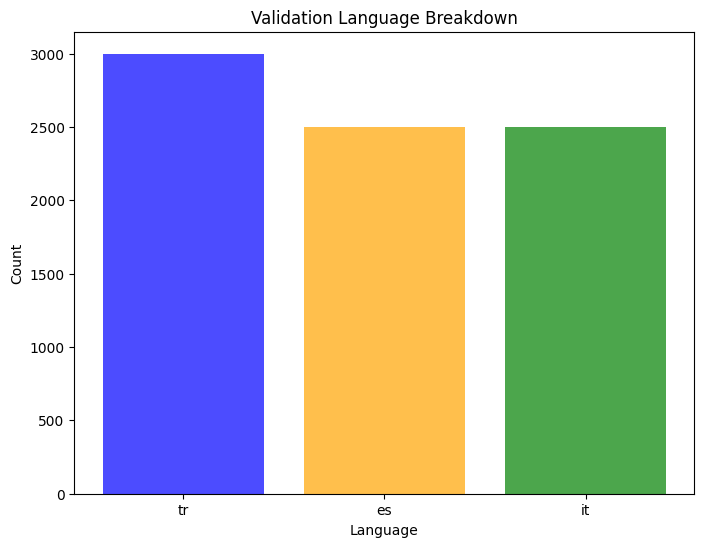

In [75]:
# Count the occurrences of each language
language_counts = df_validation['lang'].value_counts()

# Create the bar chart for language breakdown
plt.figure(figsize=(8, 6))
plt.bar(language_counts.index, language_counts.values, color=['blue', 'orange', 'green'],alpha=0.7)
plt.title('Validation Language Breakdown')
plt.xlabel('Language')
plt.ylabel('Count')
plt.show()


([<matplotlib.axis.XTick at 0x78e6f015c610>,
 [Text(0, 0, 'es'), Text(1, 0, 'it'), Text(2, 0, 'tr')])

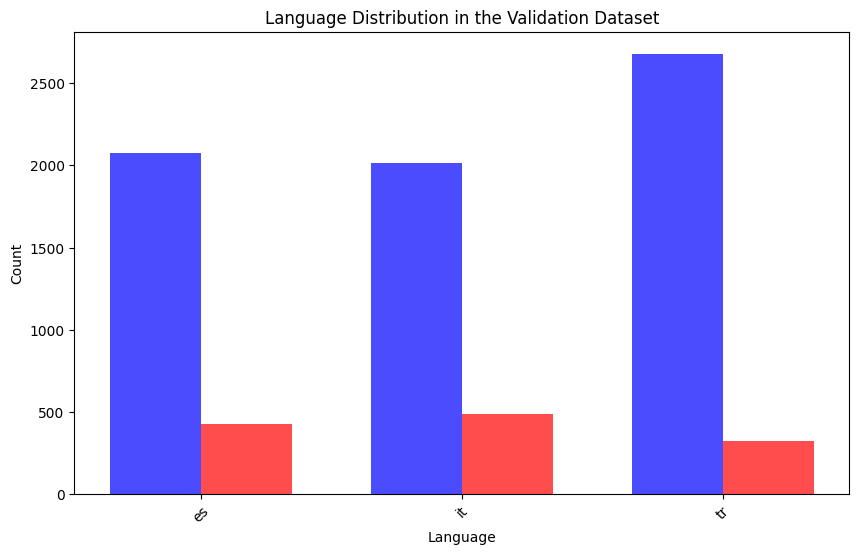

In [76]:
# Count toxic and non-toxic comments for each language
toxic_counts = df_validation[df_validation['toxic'] == 1]['lang'].value_counts()
non_toxic_counts = df_validation[df_validation['toxic'] == 0]['lang'].value_counts()

# Align indexes to ensure both counts match across all languages
all_languages = non_toxic_counts.index.union(toxic_counts.index)
toxic_counts = toxic_counts.reindex(all_languages, fill_value=0)
non_toxic_counts = non_toxic_counts.reindex(all_languages, fill_value=0)

# Create positions for grouped bar chart
x = np.arange(len(all_languages))  # Position of bars
width = 0.35  # Bar width

# Plot bars side by side
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, non_toxic_counts.values, width, label='Non-toxic', color='blue',alpha=0.7)
plt.bar(x + width/2, toxic_counts.values, width, label='Toxic', color='red', alpha=0.7)

# Add labels and title
plt.title('Language Distribution in the Validation Dataset')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(x, all_languages, rotation=45)  # Add langua



In [77]:
df_test=pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv")

In [78]:
df_test.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [79]:
df_test_labels=pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test_labels.csv")

In [80]:
df_test_labels.head()

,id,toxic
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0


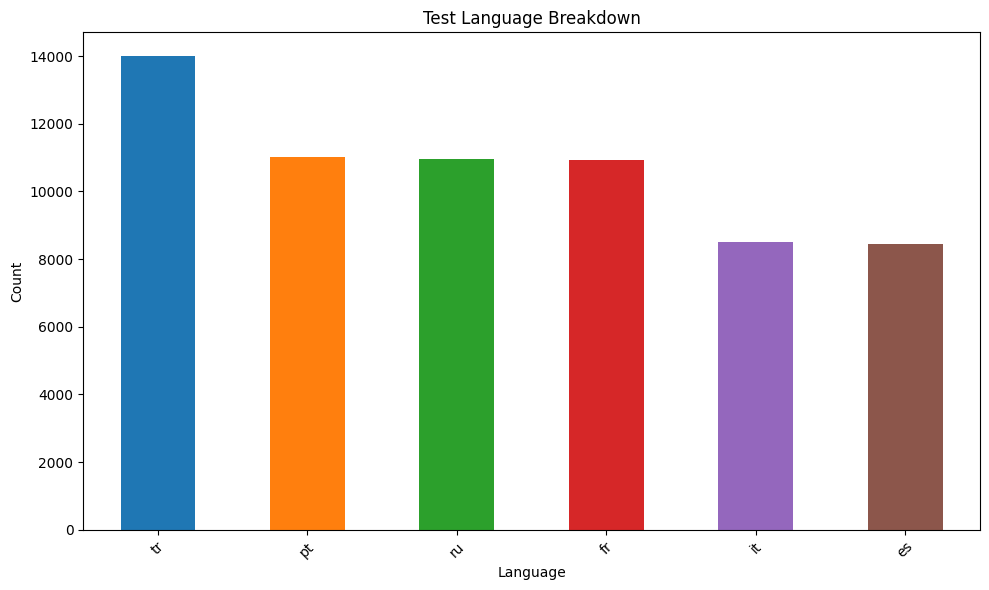

In [81]:
# Count the occurrences of each language in the test dataset
language_counts = df_test['lang'].value_counts()

# Plot the bar chart with new colors
plt.figure(figsize=(10, 6))
language_counts.plot(
    kind='bar', 
    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # Custom color palette
)
plt.title('Test Language Breakdown')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [82]:
def W_Cloud(token):
    """
    Visualize the most common words contributing to the token.
    """
    threat_context = df[df[token] == 1]
    threat_text = threat_context.comment_text
    neg_text = pd.Series(threat_text).str.cat(sep=' ')
    wordcloud = WordCloud(width=1600, height=800,
                          max_font_size=200).generate(neg_text)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most common words assosiated with {token} comment", size=20)
    plt.show()

Choose a class to visualize the most common words contributing to the class: toxic


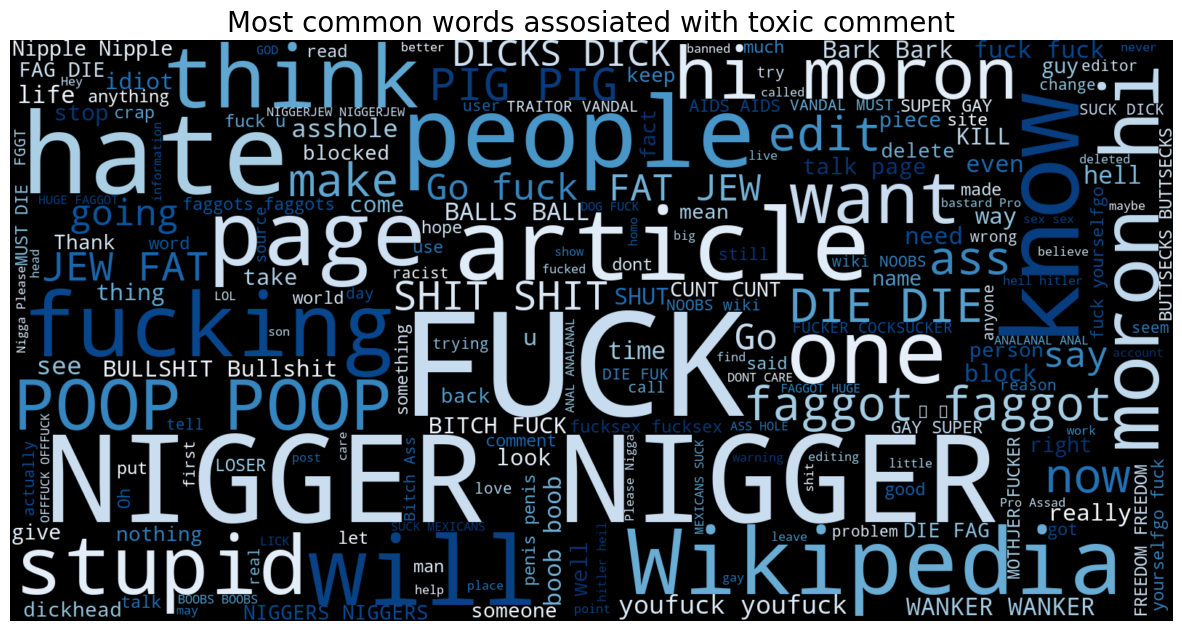

In [83]:
from wordcloud import WordCloud
token = input(
    'Choose a class to visualize the most common words contributing to the class:')
W_Cloud(token.lower())

In [84]:
# !pip install transformers 

In [85]:
# from transformers import BertTokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [86]:
# def tokenize_and_split(text, tokenizer, max_length=512):
#     tokens = tokenizer.encode_plus(
#         str(text),
#         add_special_tokens=True,  # Add special tokens like [CLS] and [SEP]
#         max_length=max_length,
#         truncation=True,  # Truncate if exceeds max_length
#         padding='max_length',  # Pad to max_length
#         return_tensors="np"  # Return as NumPy arrays
#     )
#     return tokens['input_ids'], tokens['token_type_ids']


In [87]:
# # Assuming `tokenizer` is already initialized
# df_train_unprocessed['tokenized_data'] = df_train_unprocessed['comment_text'].apply(lambda x: tokenize_and_split(x, tokenizer))

# # Separate into individual columns for clarity
# df_train_unprocessed['input_word_ids'] = df_train_unprocessed['tokenized_data'].apply(lambda x: x[0])
# df_train_unprocessed['all_segment_id'] = df_train_unprocessed['tokenized_data'].apply(lambda x: x[1])

#  # Drop intermediate column if no longer needed
# # df.drop(columns=['tokenized_data'], inplace=True)


In [93]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers

from tokenizers import BertWordPieceTokenizer

In [117]:
from tqdm.auto import tqdm  # This works well in Jupyter notebooks and scripts
# OR
from tqdm import tqdm  # Standard import for most Python environments

In [123]:
from tqdm import tqdm
import numpy as np

def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(pad_to_multiple_of=32)  # Use this instead of max_length
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [105]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.MirroredStrategy()

# Configuration
EPOCHS = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192



In [101]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [102]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [124]:
MAX_LEN=192
x_train = fast_encode(df.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(df_validation.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_test = fast_encode(df_test.content.astype(str), fast_tokenizer, maxlen=MAX_LEN)


y_train = df.toxic.values
y_valid = df_validation.toxic.values

100%|██████████| 250/250 [00:11<00:00, 21.10it/s]


array([[  101, 27746, 31609, ...,     0,     0,     0],
       [  101,   141,   112, ...,     0,     0,     0],
       [  101, 35936, 10817, ...,     0,     0,     0],
       ...,
       [  101,   134,   134, ...,     0,     0,     0],
       [  101, 47430, 11369, ...,     0,     0,     0],
       [  101,   107,   134, ...,     0,     0,     0]])

In [125]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [160]:
def build_model(transformer, max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [161]:
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


ValueError: Exception encountered when calling layer 'tf_distil_bert_model_17' (type TFDistilBertModel).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for input_ids.

Call arguments received by layer 'tf_distil_bert_model_17' (type TFDistilBertModel):
  • input_ids=<KerasTensor shape=(None, 512), dtype=int32, sparse=None, name=input_word_ids>
  • attention_mask=None
  • head_mask=None
  • inputs_embeds=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • training=False

In [ ]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

In [ ]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS*2
)

In [164]:
sub=pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [ ]:
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)